In [1]:
!pip install tensorflow==2.0.0-beta1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


In [0]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  
  
def trend(time, slope = 0):
  return slope * time


def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [0]:
## Create the series
series = baseline + trend(time, slope) + \
         seasonality(time, period = 365, amplitude = amplitude)

## Update with noise
series += noise(time, noise_level, seed = 42)

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, 
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30

train_set = windowed_dataset(x_train, window_size, batch_size = 128,
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 100,
                    callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 666ms/step - loss: 73.7833 - mae: 74.1150
Epoch 2/100
8/8 [==============================] - 1s 125ms/step - loss: 73.0351 - mae: 73.3971
Epoch 3/100
8/8 [==============================] - 1s 125ms/step - loss: 71.8754 - mae: 72.2451
Epoch 4/100
8/8 [==============================] - 1s 125ms/step - loss: 70.4263 - mae: 70.8026
Epoch 5/100
8/8 [==============================] - 1s 123ms/step - loss: 68.7344 - mae: 69.1172
Epoch 6/100
8/8 [==============================] - 1s 124ms/step - loss: 66.8004 - mae: 67.1908
Epoch 7/100
8/8 [==============================] - 1s 123ms/step - loss: 64.6024 - mae: 65.0022
Epoch 8/100
8/8 [==============================] - 1s 122ms/step - loss: 62.0938 - mae: 62.5067
Epoch 9/100
8/8 [==============================] - 1s 122ms/step - loss: 59.2056 - mae: 59.6389
Epoch 10/100
8/8 [==============================] - 1s 124ms/step - loss: 55.8366 - mae: 56.3058
Epoch 11/100
8/8 [=====================

[1e-08, 0.0001, 0, 30]

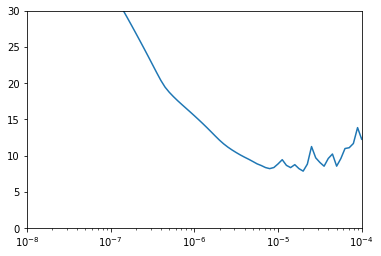

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

## batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size = 128,
                           shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(dataset, epochs = 500)

Epoch 1/500
8/8 [==============================] - 3s 424ms/step - loss: 38.6268 - mae: 39.7686
Epoch 2/500
8/8 [==============================] - 1s 66ms/step - loss: 19.0458 - mae: 19.5498
Epoch 3/500
8/8 [==============================] - 1s 66ms/step - loss: 15.2087 - mae: 15.7173
Epoch 4/500
8/8 [==============================] - 1s 67ms/step - loss: 13.0906 - mae: 13.5268
Epoch 5/500
8/8 [==============================] - 1s 66ms/step - loss: 11.6730 - mae: 12.1230
Epoch 6/500
8/8 [==============================] - 1s 68ms/step - loss: 10.9385 - mae: 11.3677
Epoch 7/500
8/8 [==============================] - 1s 64ms/step - loss: 10.7116 - mae: 11.1400
Epoch 8/500
8/8 [==============================] - 1s 66ms/step - loss: 10.3914 - mae: 10.8152
Epoch 9/500
8/8 [==============================] - 1s 65ms/step - loss: 10.1415 - mae: 10.5638
Epoch 10/500
8/8 [==============================] - 1s 68ms/step - loss: 9.9521 - mae: 10.3764
Epoch 11/500
8/8 [==============================]

In [0]:
lstm_forecast = model_forecast(model, series[..., np.newaxis],
                               window_size)

lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

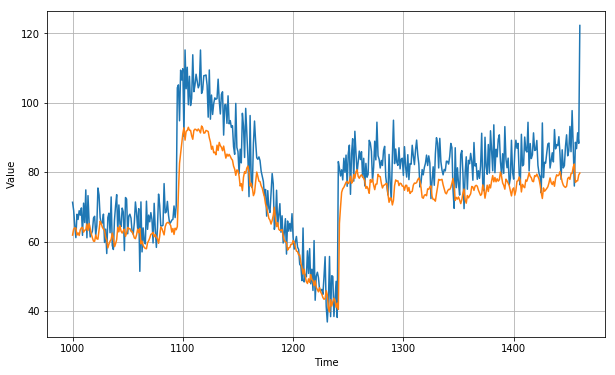

In [16]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

7.7022557

<Figure size 432x288 with 0 Axes>

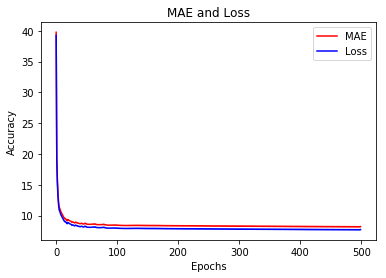

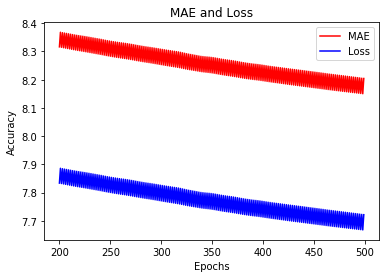

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-------------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-------------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-------------------------------------------------------------
# Plot MAE and Loss
#-------------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#-------------------------------------------------------------
# Plot Zoomed MAE and Loss
#-------------------------------------------------------------

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


dataset = windowed_dataset(x_train, window_size, batch_size = 32,
                           shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(dataset, epochs = 500)

Epoch 1/500
31/31 [==============================] - 4s 122ms/step - loss: 23.3611 - mae: 24.0496
Epoch 2/500
31/31 [==============================] - 1s 33ms/step - loss: 11.1061 - mae: 11.5313
Epoch 3/500
31/31 [==============================] - 1s 33ms/step - loss: 10.0097 - mae: 10.4224
Epoch 4/500
31/31 [==============================] - 1s 34ms/step - loss: 9.5442 - mae: 9.9376
Epoch 5/500
31/31 [==============================] - 1s 34ms/step - loss: 9.4305 - mae: 9.8611
Epoch 6/500
31/31 [==============================] - 1s 34ms/step - loss: 8.9082 - mae: 9.3352
Epoch 7/500
31/31 [==============================] - 1s 34ms/step - loss: 9.0169 - mae: 9.4097
Epoch 8/500
31/31 [==============================] - 1s 35ms/step - loss: 9.0282 - mae: 9.4328
Epoch 9/500
31/31 [==============================] - 1s 34ms/step - loss: 8.9093 - mae: 9.3136
Epoch 10/500
31/31 [==============================] - 1s 34ms/step - loss: 8.8438 - mae: 9.2456
Epoch 11/500
31/31 [======================

In [0]:
lstm_forecast2 = model_forecast(model, series[..., np.newaxis],
                                window_size)

lstm_forecast2 = lstm_forecast2[split_time - window_size:-1, -1, 0]

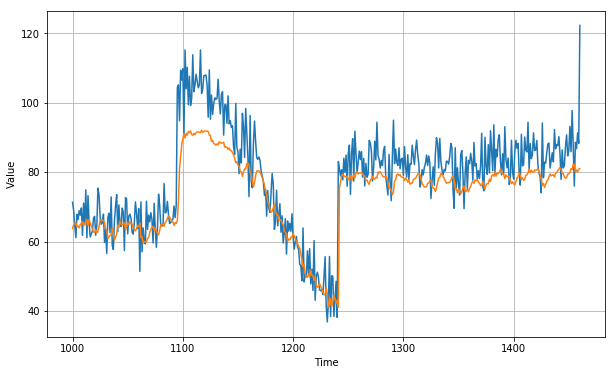

In [22]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast2)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast2).numpy()

6.506223

<Figure size 432x288 with 0 Axes>

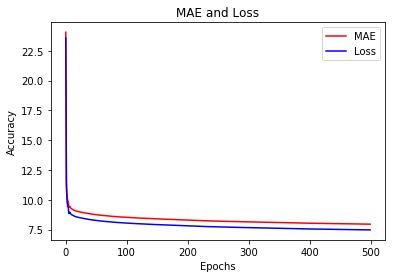

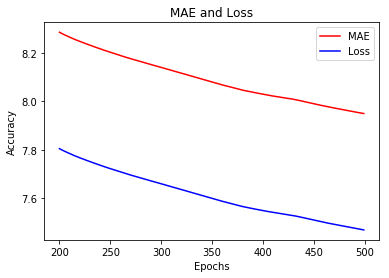

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-------------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-------------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-------------------------------------------------------------
# Plot MAE and Loss
#-------------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#-------------------------------------------------------------
# Plot Zoomed MAE and Loss
#-------------------------------------------------------------

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()